# Environment setup

In [59]:
import os
import gc
import cv2
import math
import copy
import time
import random
import glob
from typing import Dict, List
from matplotlib import pyplot as plt
import seaborn as sns
from random import sample
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision

# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

# For Image Models
import timm
from PIL import Image

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# For colored terminal text
from colorama import Fore, Back, Style
b_ = Fore.BLUE
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,60))
print(f"torch version {torch.__version__}") 
print(f'Torchvision version {torchvision.__version__}')

torch version 2.0.0
Torchvision version 0.15.1


In [60]:
CONFIG = {
    "seed": 42,
    "img_size": 2400,
    "num_tiles": 16,
    "model_name": "effnet-600-tiles-30e",
    "num_classes": 5,
    "valid_batch_size": 1,
    "test_batch_size": 1,
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "train": False, # To train and save the model. Should be False when submitting
    "split_ratio": 0.2,
    "num_workers": os.cpu_count(),
    "epochs": 50,
    "sandbox": True, # True when finding optimal hyperparameters. Should be False when submitting.
}

In [61]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
# set_seed(CONFIG['seed'])

In [62]:
ROOT_DIR = '/kaggle/input/processed-ubc-thumbnails'
TRAIN_DIR = '/kaggle/input/processed-ubc-thumbnails/train_thumbnails_600/train_thumbnails'

# Data processing

In [63]:
def trim(im):
    """
    Converts the image to grayscale using cv2, then computes binary matrix
    of the pixels that are above a certrain threshold, then takes out the first
    row where a certain percentage of the pixels are above the threshold will
    be the first clip point. Same idea for col, max row, max col.
    """

    percentage = 0.002
    upper_percentage = 0.97

    img = (np.array(im))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    row_sums = np.sum(img_gray, axis=1)
    col_sums = np.sum(img_gray, axis=0)
    rows = np.where(np.logical_or(row_sums < img.shape[1] * percentage,
                                  row_sums > img.shape[1] * upper_percentage))[0]
    cols = np.where(np.logical_or(col_sums < img.shape[0] * percentage,
                                  col_sums > img.shape[0] * upper_percentage))[0]
    im_crop = np.delete(img, rows, axis=0)
    im_crop = np.delete(im_crop, cols, axis=1)
    return im_crop*255

In [64]:
class UBCDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df
        self.file_names = df['file_path'].values
        self.labels = df['label'].values
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        folder_path = self.file_names[index]
        tiles_file_paths = os.listdir(folder_path)
        tiles = []
        for tile_path in tiles_file_paths:
            tile = plt.imread(os.path.join(folder_path, tile_path))[:,:,:3]
            if self.transforms:
                tile = self.transforms(image=tile)["image"]
            tiles.append(tile)
            
        label = self.labels[index]
        
        return tiles, torch.tensor(label)
        

In [65]:
data_transforms = {
    "valid": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        #A.Normalize(
        #        mean=[0.485, 0.456, 0.406], 
        #        std=[0.229, 0.224, 0.225], 
        #        max_pixel_value=255.0, 
        #        p=1.0
        #    ),
        ToTensorV2()], p=1.),
    "train": A.Compose([
        A.Resize(CONFIG['img_size'], CONFIG['img_size']),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
        A.GaussNoise(var_limit=[10, 50]),
        A.GaussianBlur(),
        A.MotionBlur(),
        ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(512* 0.3), max_height=int(512* 0.3), mask_fill_value=0, p=0.5),
        A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225], 
                max_pixel_value=255.0, 
                p=1.0
            ),
        ToTensorV2()], p=1.)
}

In [66]:
def get_train_file_path(image_id):
    if os.path.exists(f"{TRAIN_DIR}/{image_id}"):
        return f"{TRAIN_DIR}/{image_id}"
    else:
        return f"NO FILE"

In [67]:
traindf = pd.read_csv('/kaggle/input/UBC-OCEAN/train.csv')
traindf

,image_id,label,image_width,image_height,is_tma
0,4,HGSC,23785,20008,False
1,66,LGSC,48871,48195,False
2,91,HGSC,3388,3388,True
3,281,LGSC,42309,15545,False
4,286,EC,37204,30020,False
...,...,...,...,...,...
533,65022,LGSC,53355,46675,False
534,65094,MC,55042,45080,False
535,65300,HGSC,75860,27503,False
536,65371,HGSC,42551,41800,False


In [68]:
traindf['file_path'] = traindf['image_id'].apply(get_train_file_path)
traindf

,image_id,label,image_width,image_height,is_tma,file_path
0,4,HGSC,23785,20008,False,/kaggle/input/processed-ubc-thumbnails/train_t...
1,66,LGSC,48871,48195,False,/kaggle/input/processed-ubc-thumbnails/train_t...
2,91,HGSC,3388,3388,True,NO FILE
3,281,LGSC,42309,15545,False,/kaggle/input/processed-ubc-thumbnails/train_t...
4,286,EC,37204,30020,False,/kaggle/input/processed-ubc-thumbnails/train_t...
...,...,...,...,...,...,...
533,65022,LGSC,53355,46675,False,/kaggle/input/processed-ubc-thumbnails/train_t...
534,65094,MC,55042,45080,False,/kaggle/input/processed-ubc-thumbnails/train_t...
535,65300,HGSC,75860,27503,False,/kaggle/input/processed-ubc-thumbnails/train_t...
536,65371,HGSC,42551,41800,False,/kaggle/input/processed-ubc-thumbnails/train_t...


## Preparing the training data frame for training

In [69]:
traindf['label'][traindf['label']=="HGSC"] = 0
traindf['label'][traindf['label']=="EC"] = 1
traindf['label'][traindf['label']=="CC"] = 2
traindf['label'][traindf['label']=="LGSC"] = 3
traindf['label'][traindf['label']=="MC"] = 4
traindf = traindf[traindf['file_path'] != 'NO FILE']
traindf

,image_id,label,image_width,image_height,is_tma,file_path
0,4,0,23785,20008,False,/kaggle/input/processed-ubc-thumbnails/train_t...
1,66,3,48871,48195,False,/kaggle/input/processed-ubc-thumbnails/train_t...
3,281,3,42309,15545,False,/kaggle/input/processed-ubc-thumbnails/train_t...
4,286,1,37204,30020,False,/kaggle/input/processed-ubc-thumbnails/train_t...
5,431,0,39991,40943,False,/kaggle/input/processed-ubc-thumbnails/train_t...
...,...,...,...,...,...,...
533,65022,3,53355,46675,False,/kaggle/input/processed-ubc-thumbnails/train_t...
534,65094,4,55042,45080,False,/kaggle/input/processed-ubc-thumbnails/train_t...
535,65300,0,75860,27503,False,/kaggle/input/processed-ubc-thumbnails/train_t...
536,65371,0,42551,41800,False,/kaggle/input/processed-ubc-thumbnails/train_t...


In [70]:
train_dataset = UBCDataset(traindf, transforms=data_transforms["train"]) # TODO: Add training transforms
train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['valid_batch_size'], 
                          num_workers=CONFIG["num_workers"], shuffle=True, pin_memory=True)

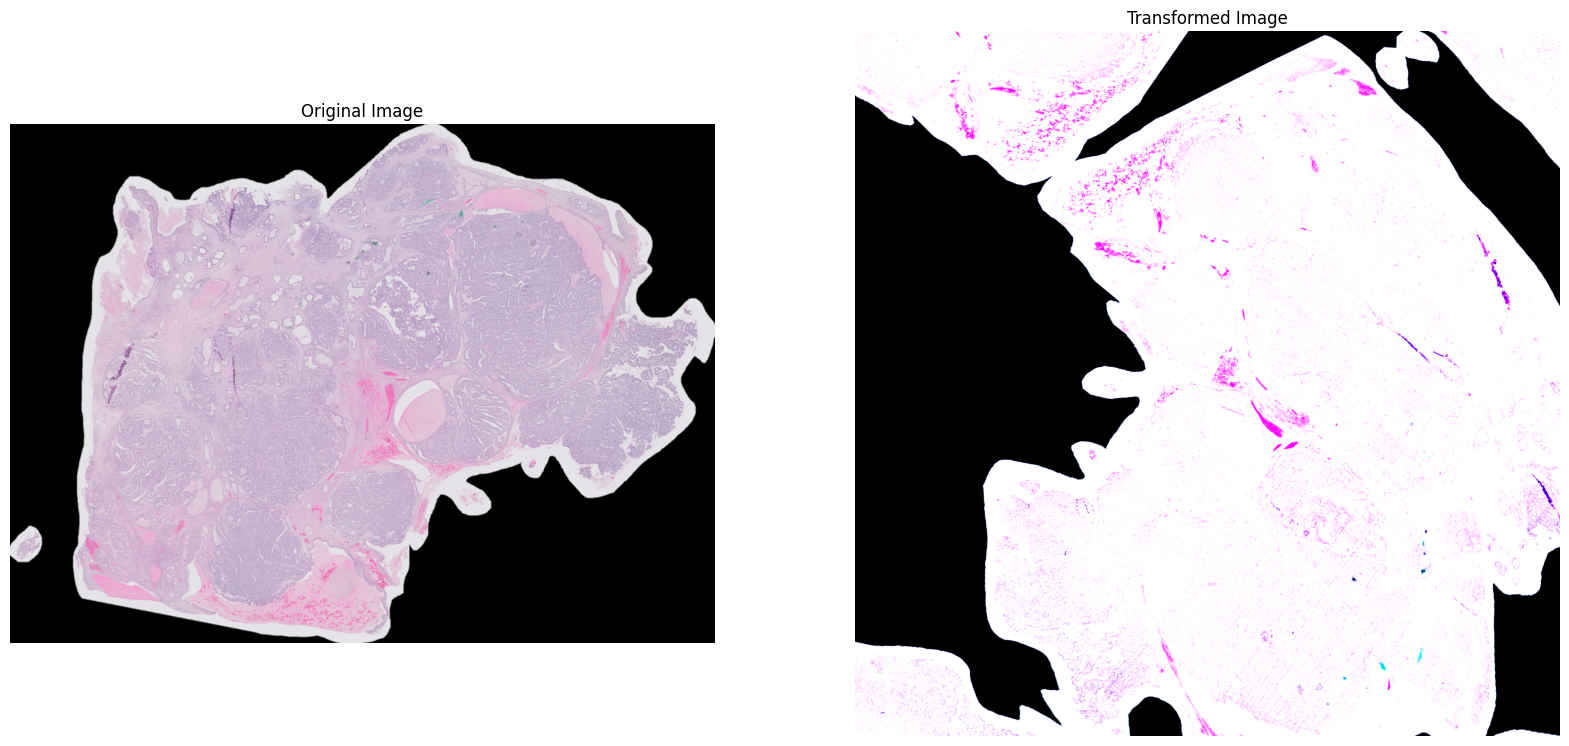

In [71]:
def visualize_transformed_image(dataframe, transform):
    # Select a random row from the DataFrame
    random_row = dataframe.sample(n=1).iloc[0]

    # Get the image file path from the selected row
    file_path = "/kaggle/input/UBC-OCEAN/train_thumbnails/10077_thumbnail.png"
    # Load the original image
    original_image = plt.imread(file_path)
    trimmed_image = trim(original_image)
    
    # Apply the transform to the original image
    transformed_image = transform(image=trimmed_image)["image"]

    # Visualize the original and transformed images
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].set_title('Original Image')
    axes[0].imshow(original_image)
    axes[0].axis('off')

    axes[1].set_title('Transformed Image')
    axes[1].imshow(transformed_image.permute(1, 2, 0))
    axes[1].axis('off')

    plt.show()

# Visualize a random image from the DataFrame with the transform applied
if CONFIG["sandbox"]:
    visualize_transformed_image(traindf, data_transforms["train"])


## Training and validation split from the training set

In [72]:
# Split the data into training and validation sets
if CONFIG["sandbox"]:
    train_data, val_data = train_test_split(traindf, test_size=CONFIG["split_ratio"], random_state=CONFIG["seed"])

    train_dataset = UBCDataset(train_data, transforms=data_transforms["train"]) # TODO: Add training transforms
    train_dataloader = DataLoader(train_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=CONFIG["num_workers"], shuffle=True, pin_memory=True)

    val_dataset = UBCDataset(val_data, transforms=data_transforms["valid"]) 
    val_dataloader = DataLoader(val_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=CONFIG["num_workers"], shuffle=False, pin_memory=True)

# Train and save model

## Save model

In [73]:
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.
    
    Args:
        model: A target PyTorch model to save.
        target_dir: A directory for saving the model to.
        model_name: A filename for the saved model. Should include either ".pth" or ".pt" as the file extension.
        
    Example usage:
        save_model(model=model_0,
        targer_dir="models", 
        model_name="model_1")
    """

    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                          exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"),  "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to : {model_save_path}")
    torch.save(obj=model,
               f=model_save_path)


## Importing a pretrained model
This is done online before we turn off the internet access. 

#### Indentity module for removing last classifier layer

In [74]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

In [75]:
if CONFIG["train"] or CONFIG["sandbox"]:
    # 1. Get pretrained weights for ViT-base
    pretrained_weights = torchvision.models.EfficientNet_B7_Weights.DEFAULT
    #pretrained_vit_weights=torch.load('/kaggle/input/vit-weights/vit_b_16-c867db91.pth')
    # 2. Setup a ViT model instance with pretrained weights
    pretrained_model = torchvision.models.efficientnet_b7(weights=pretrained_weights).to(CONFIG["device"])

    # 3. Freeze the base parameters
    for parameter in pretrained_model.parameters():
        parameter.requires_grad = False
        parameter.to(CONFIG["device"])

    # 4. Change the classifier head
    # set_seed()
    # print(pretrained_model)

    pretrained_model.classifier = Identity()
    pretrained_model

    save_model(pretrained_model, # Needs to be saved as a dataset so that it works offline
             "/kaggle/working/",
             f"{CONFIG['model_name']}-pretrained.pth")

[INFO] Saving model to : /kaggle/working/effnet-600-tiles-30e-pretrained.pth


In [76]:
def split_images_into_tiles(image_batch, tile_size):
    # Get the dimensions of the input image batch
    batch_size, channels, input_height, input_width = image_batch.shape

    
    # Calculate the number of tiles in the height and width directions
    num_tiles_height = input_height // tile_size
    num_tiles_width = input_width // tile_size

    # Initialize the output batch
    output_batch = torch.zeros((batch_size, num_tiles_height * num_tiles_width, channels, tile_size, tile_size)).to(CONFIG["device"])

    # Split each image in the batch into tiles
    for b in range(batch_size):
        for i in range(num_tiles_height):
            for j in range(num_tiles_width):
                h_start = i * tile_size
                h_end = (i + 1) * tile_size
                w_start = j * tile_size
                w_end = (j + 1) * tile_size
                tile = image_batch[b, :, h_start:h_end, w_start:w_end]
                output_batch[b, i * num_tiles_width + j] = tile

    return torch.tensor(output_batch, dtype=torch.float32)

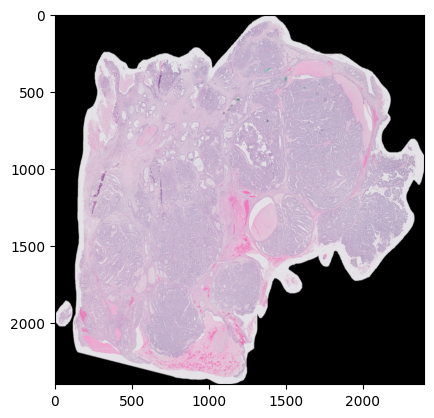

torch.Size([1, 3, 2400, 2400])
torch.Size([1, 16, 3, 600, 600])
4
4
torch.Size([16, 3, 600, 600])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])
torch.Size([600, 600, 3])


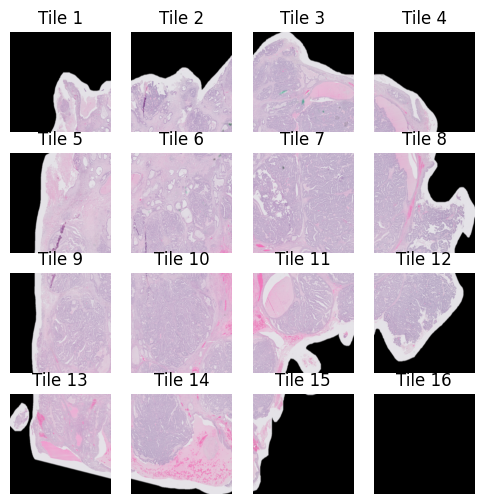

In [81]:
if CONFIG["train"] or CONFIG["sandbox"]:
    # Define the number of rows and columns in the grid
    rows, cols = CONFIG["img_size"] // 600, CONFIG["img_size"] // 600

    img = plt.imread("/kaggle/input/UBC-OCEAN/train_thumbnails/10077_thumbnail.png")
    img = data_transforms["valid"](image=trim(img))["image"]
    plt.imshow(img.permute(1, 2, 0)/255)
    plt.show()

    img_batch = img.unsqueeze(0)
    print(img_batch.shape)
    # Split the transformed image into tiles
    images = split_images_into_tiles(img_batch, 600)
    print(images.shape)
    # Ensure you have enough tiles for the 2x2 grid
    print(rows)
    print(cols)
    if len(images[0]) >= rows * cols:
        for i, image in enumerate(images):
            fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
            print(image.shape)
            for i in range(rows):
                for j in range(cols):
                    tile_index = i * cols + j
                    tile = image[tile_index].permute(1, 2, 0)
                    print(tile.shape)
                    axes[i, j].imshow(tile.cpu().numpy()/255)
                    axes[i, j].set_title(f"Tile {tile_index + 1}")
                    axes[i, j].axis('off')
            plt.show()
    else:
        print(f"Not enough tiles to create a {rows}x{cols} grid.")

In [ ]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM,self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool1d(x.clamp(min=eps).pow(p), x.size(-1)).pow(1./p) # Changed to 1d since we only want to pool over the tiles dimension
        
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'

In [ ]:
pooling = GeM()
test_vector = torch.randn((16, 25, 2560))
print(test_vector.permute(0, 2, 1).shape)
print(pooling(test_vector.permute(0, 2, 1)).squeeze(dim=-1).shape)

In [ ]:
test_vector = torch.randn((16, 25, 2560))
test_vector = test_vector.mean(dim=(-2))
print(test_vector.shape)
print(test_vector.shape)

In [ ]:
class tilingModel(nn.Module):
    def __init__(self, backbone, backbone_output_dim):
        super().__init__()
        self.backbone = backbone.to(CONFIG["device"])
        self.GeM_pooling = GeM()
        self.head = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(in_features=backbone_output_dim, out_features=1024),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=1024, out_features=128),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(in_features=128, out_features=CONFIG["num_classes"]),
    ).to(CONFIG["device"])
        
    def forward(self, x):
        batch_features = torch.tensor([]).to(CONFIG["device"])
        tiles = torch.stack(x, dim=0).squeeze(1)
        batch_features = torch.cat((batch_features, self.backbone(tiles.to(CONFIG["device"])).unsqueeze(1)), dim = 1)
        batch_features = batch_features.mean(dim=(0)) # Average pooling
        # batch_features = batch_features.max(dim=(0)) # Max pooling
        # batch_features = self.GeM_pooling(batch_features.permute(0, 2, 1)).squeeze(dim=-1)
        x = self.head(batch_features)
        return(x)

if CONFIG["train"] or CONFIG["sandbox"]:                                                                        
    tilingmodel = tilingModel(pretrained_model, 2560).to(CONFIG["device"])
    batch, label = next(iter(train_dataloader))
    print(len(batch))
    print(batch[0].shape)
    output = tilingmodel(batch)
    print(f"Shape of output: {output.shape}")
    print(output)

## Training the model

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        y = y.to(device)
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 

    # Setup test loss and test accuracy values
    test_loss, test_acc, balanced_acc = 0, 0, 0
    pred_labels = []
    true_labels = []
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            y = y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            pred_labels = pred_labels + test_pred_labels.cpu().tolist()
            true_labels = true_labels + y.cpu().tolist()

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    balanced_acc = balanced_accuracy_score(true_labels, pred_labels)
    return test_loss, test_acc, balanced_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for 
    each epoch.
    In the form: {train_loss: [...],
                  train_acc: [...],
                  test_loss: [...],
                  test_acc: [...]} 
    For example if training for epochs=2: 
                 {train_loss: [2.0616, 1.0537],
                  train_acc: [0.3945, 0.3945],
                  test_loss: [1.2641, 1.5706],
                  test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
                "train_acc": [],
                "test_loss": [],
                "test_acc": [],
                "balanced_acc": [],
                }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc, balanced_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_acc: {train_acc:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_acc: {test_acc:.4f} | "
                f"balanced_acc: {balanced_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["balanced_acc"].append(balanced_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Assuming traindf is a DataFrame with a 'label' column
class_counts = traindf['label'].value_counts()

total_samples = len(traindf)
class_weights = torch.tensor(total_samples / class_counts, dtype=torch.float)
other = torch.tensor([0.0])
# class_weights = torch.cat((class_weights, other), dim=0)

# Normalize weights to sum to 1
class_weights = class_weights / class_weights.sum()

print("Class Weights:", class_weights)
class_counts

In [ ]:
# Create optimizer and loss function
def train_model(train_dl, test_dl, model_name, store_model=True):
    # tilingmodel = tilingModel(pretrained_model, 4, 600, 2560).to(CONFIG["device"])
    tilingmodel = torch.load('/kaggle/input/effnet-th-tiles-25-trained/effnet-tiles-4-100e.pth')
    optimizer = torch.optim.Adam(params=tilingmodel.parameters(),
                                 lr=1e-3)
    
    # loss_fn = torch.nn.CrossEntropyLoss()
    loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(CONFIG["device"]))
    
    if test_dl is None:
        test_dl = train_dl
    # Train the classifier head of the pretrained ViT feature extractor model
    # set_seed()
    results = train(model=tilingmodel,
                   train_dataloader=train_dl,
                   test_dataloader=test_dl,
                   optimizer=optimizer,
                   loss_fn=loss_fn,
                   epochs=CONFIG["epochs"],
                   device=CONFIG["device"])
    if store_model:
        save_model(tilingmodel, # Needs to be saved as a dataset so that it works offline
                 "/kaggle/working/",
                 model_name)
        
    return results

In [ ]:
if CONFIG["train"]:
    results = train_model(train_dl=train_dataloader, test_dl=train_dataloader, model_name=f"{CONFIG['model_name']}.pth")
elif CONFIG["sandbox"]:
    results = train_model(train_dl=train_dataloader, test_dl=val_dataloader, model_name=f"{CONFIG['model_name']}.pth")

In [ ]:
# VGG B, 256, 32, 32

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    
    # Plot accuracy
    plt.subplot(1, 1, 1)
    plt.plot(epochs, results["balanced_acc"], label='balanced_acc')
    plt.title('Balanced Accuracy for validation data')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [ ]:
# Plot the loss curves
if CONFIG["train"] or CONFIG["sandbox"]:
    plot_loss_curves(results) 

## Testing the model

In [ ]:
if CONFIG["train"] or CONFIG["sandbox"]:
    model = torch.load(f"/kaggle/working/{CONFIG['model_name']}.pth")
else:
    # model = torch.load(f"/kaggle/input/{CONFIG['model_name']}-trained/{CONFIG['model_name']}.pth") # Needs to be loaded from the input folder so that it works offline
    model = torch.load("/kaggle/input/effnet-th-tiles-25-trained/effnet-tiles-4-130e.pth")

In [ ]:
class_names = ["HGSC","EC","CC","LGSC","MC"]

# Function to load the model and predict on selected image
def predict_on_image(model, image_path, device=CONFIG["device"]):
    print(device)
    # Load the image and turn it into torch.float32 (same type as model)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Preprocess the image to get it between 0 and 1
    transform = data_transforms["valid"]
    
    image = transform(image=img)["image"] # make sure image has batch dimension (shape: [batch_size, height, width, color_channels])
    image = torch.tensor(np.expand_dims(image, axis=0))
    print(image.to(device).dtype)
    
    # Predict on image
    model.eval()
    with torch.inference_mode():
        # Put image to target device
        image = image.to(device)
        print(image.device)
        
        # Get prediction logits
        pred_logits = model(image)
        print(pred_logits)
        # Get prediction probabilities
        pred_probs = torch.softmax(pred_logits, dim=1)

        # Get prediction label
        pred_label = torch.argmax(pred_probs, dim=1).detach().cpu()
        pred_label_class = class_names[pred_label]

    print(f"[INFO] Pred label: {pred_label} Pred class: {pred_label_class}, Pred prob: {pred_probs.max():.3f}")

In [ ]:
CONFIG["device"]
class_names[int(traindf['label'][traindf['image_id']==10077])]

In [ ]:
if CONFIG["train"]:
    predict_on_image(model, "/kaggle/input/UBC-OCEAN/train_thumbnails/10077_thumbnail.png", device=CONFIG["device"])

In [ ]:
# Plot images and make predictions for manual testing
def show_images_from_dataframe(dataframe, num_images):
    # Select 'num_images' random rows from the DataFrame
    selected_rows = dataframe.sample(num_images)
    
    for _, row in selected_rows.iterrows():
        file_path = row['file_path']
        image = cv2.imread(file_path)
        
        plt.figure(figsize=(30, 30))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image ID: {row['image_id']}")
        plt.axis('off')
        plt.show()
    return selected_rows

if CONFIG["sandbox"]:        
    selected_rows = show_images_from_dataframe(val_data, 5)

In [ ]:
def predict_and_visualize_images_with_labels(selected_rows, model):
    model.eval()

    for _, row in selected_rows.iterrows():
        file_path = row['file_path']
        image = cv2.imread(file_path)

        # Apply the transform to the original image
        transformed_image = data_transforms["valid"](image=image)["image"].unsqueeze(0).to(CONFIG["device"])

        # Perform inference
        with torch.no_grad():
            output = model(transformed_image)

        # Get the predicted class label
        predicted_class = torch.argmax(output).item()

        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Image ID: {row['image_id']}\nTrue Label: {class_names[row['label']]}\nPredicted Label: {class_names[predicted_class]}")
        plt.axis('off')
        plt.show()
        
if CONFIG["sandbox"]:       
    predict_and_visualize_images_with_labels(selected_rows, model)

In [ ]:
def get_label(label):
    return class_names[label]

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

if CONFIG["sandbox"]:
    preds = []
    true = []
    with torch.no_grad():
        bar = tqdm(enumerate(val_dataloader), total=len(val_dataloader))
        for step, (data, y) in bar:        
            images = data.to(CONFIG["device"], dtype=torch.float)        
            batch_size = images.size(0)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true.append(y.detach().cpu().numpy())
            preds.append(predicted.detach().cpu().numpy())
    preds = [get_label(item) for item in np.concatenate(preds).flatten()]
    true = [get_label(item) for item in np.concatenate(true).flatten()]

    # Compute the confusion matrix
    cm = confusion_matrix(true, preds)

    # Create a ConfusionMatrixDisplay with display_labels parameter
    cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    cmd.plot(cmap=plt.cm.Blues)  # You can choose a different color map if needed
    plt.show()